In [0]:
%matplotlib inline

In [26]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision import models, datasets
from skimage import io, transform
import copy
import os
import numpy as np

In [64]:
all_data.classes

['fakes', 'orig']

In [0]:
dataset_dir = "drive/My Drive/GoghNet/data/dataset"
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.CenterCrop(200),
    transforms.ToTensor()
])
all_data = datasets.ImageFolder(dataset_dir, transform=transform)
n = len(all_data)
indices = torch.randperm(n)
n_test = int(.1 * n)
test_set = torch.utils.data.Subset(all_data, range(0, n_test))
val_set = torch.utils.data.Subset(all_data, range(n_test, 2 * n_test))
train_set = torch.utils.data.Subset(all_data, range(2 * n_test, n))

dataloaders = {}
dataloaders['test'] = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=4)
dataloaders['train'] = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
dataloaders['val'] = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True, num_workers=4)

In [0]:
# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [0]:
model_ft = models.resnet18(pretrained=True)

# freeze model
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model_ft.parameters())

In [109]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("Epoch {}".format(epoch))
    for phase in ['train', 'val']:
      if phase == 'train':
        model_ft.train()
      else:
        model_ft.eval()
      num_correct = 0
      total = 0
      for i, data in enumerate(dataloaders[phase]):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model_ft(inputs)
          _, predicted = torch.max(outputs, 1)
          num_correct += (predicted==labels).sum().item()
          total += labels.size(0)

          loss = criterion(outputs, labels)
          if phase == 'train': 
            loss.backward()
            optimizer.step()
      print("{} acc: {}".format(phase, num_correct / total))
        
        

Epoch 0
train acc: 0.9065281899109793
val acc: 0.7619047619047619
Epoch 1
train acc: 0.9599406528189911
val acc: 0.9761904761904762
Epoch 2
train acc: 0.956973293768546
val acc: 0.9404761904761905
Epoch 3
train acc: 0.956973293768546
val acc: 0.9523809523809523
Epoch 4
train acc: 0.9614243323442137
val acc: 0.9523809523809523


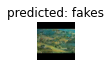

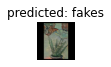

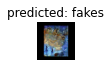

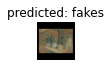

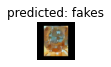

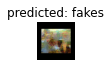

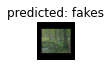

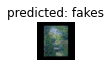

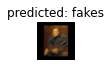

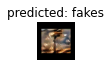

In [123]:
# from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
class_names = ['fakes', 'orig']
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)